#### Данный ноутбук посвящен оценке качества и инференсу модели, обученной с помощью BERT!

#### Подробные комментарии к функциям и классам для train не даются, их можно увидеть (как и сам train_val loop) в ноутбуке про обучение модели [¡тык!](transformer_learn_BERT_notebook.ipynb)

#### Инференс и подсчет качества сразу после функции train_model()

In [1]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install datasets accelerate nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=787cfdd93687aa3478c8be5b054c89d739ab897aeb59c03c34901e9ec1dac0a3
  Stored in directory: /root/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import string
import sys
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import datetime

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, random_split,  RandomSampler, SequentialSampler
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import summary, writer, SummaryWriter

from tqdm.notebook import tqdm


#### Устанавливаем Seed'ы:

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

import warnings
warnings.filterwarnings("ignore")

#### Задаём device:

In [5]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


#### Импортируем и устанавливаем дополнительно все, что необходимо:

In [6]:
!git clone https://github.com/KuzmaKhrabrov/character-tokenizer.git

Cloning into 'character-tokenizer'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 20 (delta 5), reused 10 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 5.89 KiB | 1.18 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [7]:
sys.path.append("/kaggle/input/tools/character-tokenizer")
from charactertokenizer import CharacterTokenizer

#### Check:

In [8]:
chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя-h"
model_max_length = 22
tokenizer = CharacterTokenizer(chars, model_max_length)

#### Encode:

In [9]:
example = "-буh"
tokens = tokenizer(example)
print(tokens)

{'input_ids': [0, 73, 10, 48, 74, 1], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


#### Decode:

In [10]:
print(tokenizer.decode(tokens["input_ids"]))

[CLS]-буh[SEP]


#### Задача:

##### Необходимо обучить модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers.

1. Написать класс для Dataset/Dataloder и разбить данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробовать обучить одну или несколько из моделей: Bert, Albert, Deberta. Посчитать метрику Accuracy на train и test. (1 балл). При преодолении порога в Accuracy на test 0.8: (+1 балл), 0.85: (+2 балла), 0.89: (+3 балла).

#### Датасет загружен, проверяем его содержимое:

In [11]:
accents_path = '/kaggle/input/accents-dataset/all_accents.tsv'
accents_dataset = pd.read_csv(accents_path, sep = '\t', header=0, encoding='utf-8', na_values='NA')

In [12]:
accents_dataset.head()

,-де,-д^е
0,-ка,-к^а
1,-либо,-л^ибо
2,-нибудь,-ниб^удь
3,-с,-с
4,-таки,-так^и


#### Немного исследований датасета:

In [13]:
# Число примеров:
print(accents_dataset.shape[0])

1680534


In [14]:
# Символьная длина слов
def word_length(word):
    return len(word)

# Один символ
def is_one_symbol(word):
    return int(len(word) == 1)

# Больше одного слова через пробел
def more_than_one_word(word):
    splitted = word.split(' ')
    return int(len(splitted) > 1)

# Подсчет символов ударения ^:
def count_hat(word):
    return len(re.findall(r'\^', word))

# Есть ли латинские буквы в слове
def contains_latin(word):
    return int(bool(re.search(r'[a-zA-Z]', word)))

# Функция для подсчета символов, которые не являются русскими буквами
def count_non_russian(word):
    return len(re.findall(r'[a-zA-Z]', word))

def letter_yo(word):
    return int(bool(re.search(r'[ёЁ]', word)))

def error_cases(word):
    pattern = r'\^[бвгджзйклмнпрстфхцчшщБВГДЖЗЙКЛМНПРСТФХЦЧШЩ]'   
    matches = re.findall(pattern, word)
    return len(matches)


accents_dataset['word_length'] = accents_dataset['-де'].map(word_length)
accents_dataset['is_one_symbol'] = accents_dataset['-де'].map(is_one_symbol)
accents_dataset['more_than_one_word'] = accents_dataset['-де'].map(more_than_one_word)
accents_dataset['hat_num'] = accents_dataset['-д^е'].map(count_hat)
accents_dataset['has_latin'] = accents_dataset['-де'].map(contains_latin)
accents_dataset['num_non_russian'] = accents_dataset['-де'].map(count_non_russian)
accents_dataset['error_cases'] = accents_dataset['-д^е'].map(error_cases)
accents_dataset['is_Ёё'] = accents_dataset['-де'].map(letter_yo)

In [15]:
# Максимальное и среднее число символов в слове:
word_max_length = accents_dataset['word_length'].max()
print(f"Максимальное число символов в слове: {word_max_length}")

# Максимальное и среднее число символов в слове:
word_mean_length = accents_dataset['word_length'].mean()
print(f"Среднее число символов в слове: {word_mean_length}")

Максимальное число символов в слове: 56
Среднее число символов в слове: 10.641052189363618


#### Посмотрим более пристально на ударения:

In [16]:
accents_count_max = accents_dataset['hat_num'].max()
print(f"Максимальное число ударений в слове: {accents_count_max}")

zero_accents_num = accents_dataset[accents_dataset['hat_num'] == 0].shape[0]
print(f"Количество случаев отсутствия ударений в словах: {zero_accents_num}")

Максимальное число ударений в слове: 1
Количество случаев отсутствия ударений в словах: 507


Ошибок нет, где у нас больше одного ударения. Однако у нас целых 507 случаев отсутствия ударений в словах:

In [17]:
accents_dataset[accents_dataset['hat_num'] == 0].head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
3,-с,-с,2,0,0,0,0,0,0,0
16107,ай,ай,2,0,0,0,0,0,0,0
16172,айвингхо,айвингхо,8,0,0,0,0,0,0,0
24766,алмондсбери,алмондсбери,11,0,0,0,0,0,0,0
27255,ам,ам,2,0,0,0,0,0,0,0
29041,амка,амка,4,0,0,0,0,0,0,0
35185,анка,анка,4,0,0,0,0,0,0,0
42254,анька,анька,5,0,0,0,0,0,0,0
62526,б,б,1,1,0,0,0,0,0,0
75305,бедерный,бедерный,8,0,0,0,0,0,0,0


Возможно, это ошибка разметки или какие-то части слов. Но где-то это справедливо ввиду отсутствия гласных букв в словах. Подобные сэмплы могут запутать модель, но их количество в целом и незначительно в сравнении с общим числов сэмплов в обучении.

#### Нерусская раскладка:

In [18]:
accents_count_latin_max = accents_dataset['num_non_russian'].max()
print(f"Максимальное число нерусских символов в слове: {accents_count_latin_max}")

accents_count_latin = accents_dataset[accents_dataset['num_non_russian'] > 0].shape[0]
print(f"Количество сэмплов, где число нерусских символов больше 0: {accents_count_latin}")

Максимальное число нерусских символов в слове: 2
Количество сэмплов, где число нерусских символов больше 0: 14


In [19]:
accents_dataset[accents_dataset['num_non_russian'] > 0]

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0
116705,буhалтер-калькулятор,буh^алтер-калькулятор,20,0,0,1,1,1,0,0
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0
116710,буhалтерша,буh^алтерша,10,0,0,1,1,1,0,0
620314,лимасcольский,лимасc^ольский,13,0,0,1,1,1,0,0
1018887,по-буhалтерски,по-буh^алтерски,14,0,0,1,1,1,0,0
1133176,прдjети,прдjети,7,0,0,0,1,1,0,0


Что ж, есть и такие сэмплы, но благо их тоже не очень-то и много.

#### Посмотрим на распределения слов по выделенным параметрам:

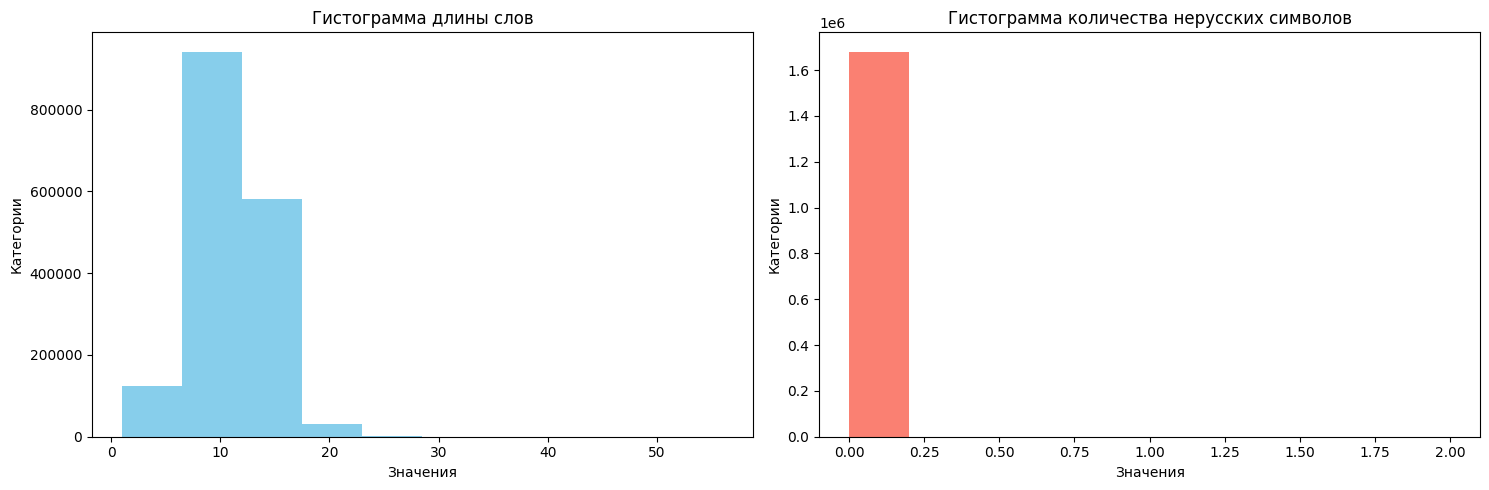

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(accents_dataset['word_length'], color='skyblue')
axs[0].set_title('Гистограмма длины слов')
axs[1].hist(accents_dataset['num_non_russian'], color='salmon')
axs[1].set_title('Гистограмма количества нерусских символов')
for ax in axs:
    ax.set_xlabel('Значения')
    ax.set_ylabel('Категории')

plt.tight_layout()
plt.show()

In [21]:
print(f"95-квантиль: {np.quantile(accents_dataset['word_length'].values, q = 0.95)}")

95-квантиль: 16.0


In [22]:
len(accents_dataset[accents_dataset['word_length'] > 20])

4477

Думаю 4500 длинных слов можно отбросить

In [23]:
accents_dataset = accents_dataset[accents_dataset['word_length'] < 20]

Итак, предварительный анализ показывает, что существуют особые сэмплы, которые могут повлиять на обобщающую способность модели. Однако их количество не такое уж и большое и, в целом, такие примеры как одна согласная могут быть довольно-таки полезными. По необходимости, отфильтруем данные позже.

Как вариант иностранные символы из латинской раскладки можно заменить транслитерацией на русские символы или, например, неизвестные символы (отличающиеся от "-") вообще убрать или заменить на другой символ. 

#### Еще хочется посмотреть, есть ли сэмплы, в которых случайно расставлены ударения на согласную букву и сэмплы, содержащие букву ёЁ, чтобы не учить модель на них:

In [24]:
print(f"Количество сэмплов с буквой Ёё: {accents_dataset[accents_dataset['is_Ёё'] != 0].shape[0]}")

print(f"Количество сэмплов с ударениям на согласную: {accents_dataset[accents_dataset['error_cases'] != 0].shape[0]}")

Количество сэмплов с буквой Ёё: 0
Количество сэмплов с ударениям на согласную: 0


Итак, букв Ёё и ошибок с ударением на согласную нет.

#### Всё же попробуем заменит английские символы транслитерацией:

In [25]:
latin_to_russian_needed = {
    'c': 'с', 'h': 'г', 'j': 'ъ', 'g': 'г'
}

def transliterate(text):
    return ''.join(latin_to_russian_needed.get(char, char) for char in text)

accents_dataset['words_upd'] = accents_dataset['-де'].map(transliterate)

In [27]:
accents_dataset[accents_dataset['num_non_russian'] > 0].head()

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
116704,буhалтер,буh^алтер,8,0,0,1,1,1,0,0,бугалтер
116706,буhалтер-ревизор,буh^алтер-ревизор,16,0,0,1,1,1,0,0,бугалтер-ревизор
116707,буhалтерия,буhалт^ерия,10,0,0,1,1,1,0,0,бугалтерия
116708,буhалтерски,буh^алтерски,11,0,0,1,1,1,0,0,бугалтерски
116709,буhалтерский,буh^алтерский,12,0,0,1,1,1,0,0,бугалтерский


#### Уберем, где нет ударений:

In [28]:
accents_dataset = accents_dataset[accents_dataset['hat_num'] > 0]

#### Итоговый датасет после некоторых преобразований:

In [29]:
accents_dataset.shape

(1671254, 11)

In [30]:
accents_dataset.head(10)

,-де,-д^е,word_length,is_one_symbol,more_than_one_word,hat_num,has_latin,num_non_russian,error_cases,is_Ёё,words_upd
0,-ка,-к^а,3,0,0,1,0,0,0,0,-ка
1,-либо,-л^ибо,5,0,0,1,0,0,0,0,-либо
2,-нибудь,-ниб^удь,7,0,0,1,0,0,0,0,-нибудь
4,-таки,-так^и,5,0,0,1,0,0,0,0,-таки
5,-то,-т^о,3,0,0,1,0,0,0,0,-то
6,­вычеркнуть,­в^ычеркнуть,11,0,0,1,0,0,0,0,­вычеркнуть
7,а,^а,1,1,0,1,0,0,0,0,а
8,а-конто,а-к^онто,7,0,0,1,0,0,0,0,а-конто
9,а-ля,а-л^я,4,0,0,1,0,0,0,0,а-ля
10,а-мольный,а-м^ольный,9,0,0,1,0,0,0,0,а-мольный


#### Теперь нужно подготовить данные для обучения

Предполагается, что есть смысл разделить слово на токены, причём каждая буква будет являться токеном. Далее можно присвоить каждому токену метку 1 или 0 в зависимости от того, является ли данный токен ударным или нет и выйти на своего рода задачу бинарной классификации для каждого токена.

In [31]:
def get_marked_dict(dataset = accents_dataset,
               input_column = 'words_upd',
               predict_column = '-д^е'):
    
    words = dataset[input_column].values
    words_accents = dataset[predict_column].values
    inputs = [word for word in words]
    labels = []
    
    for word, accents in tqdm(zip(words, words_accents)):
        label = [0] * (len(word) + 2)
        for i, char in enumerate(accents):
            if char == '^':
                label[i+1] = 1
                
        labels.append(label)
    return {"input_words" : inputs,
           "labels" : labels}
        
words_labels = get_marked_dict()

0it [00:00, ?it/s]

In [32]:
def get_example(dict = words_labels,
                idx = 0):
    print(words_labels['input_words'][idx], words_labels['labels'][idx])
    
get_example(idx = 1001)

абердинского [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


Вроде как размечено корректно. Создаем torc.utils.data.Dataset из словаря:

In [33]:
class AccentDataset(Dataset):
    def __init__(self, words_labels = words_labels,
                 tokenizer = tokenizer,
                 max_len = 22):
        self.data = words_labels
        self.tokenizer = tokenizer
        self.max_model_length = max_len
        
    def __len__(self):
        return len(self.data['input_words'])
    
    def __getitem__(self, idx, idx_to_token = False):
        input_word, accent_labels = self.data['input_words'][idx], self.data['labels'][idx]
        
        encoding = self.tokenizer.encode_plus(
            input_word,
            add_special_tokens=True,
            max_length=self.max_model_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        labels = torch.tensor(accent_labels, dtype=torch.long)
        padding_length = self.max_model_length - labels.size(0)
        idx = np.where(labels == 1)[0]
        if len(idx) == 0:
            print(input_ids)
            print(labels)
            print(convert_to_tokens(input_ids.tolist()))

        if idx_to_token == True:
            return {
                'input_ids': self.tokenizer.convert_ids_to_tokens(input_ids),
                'attention_mask': attention_mask,
                'labels': idx
                }
        return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'labels': idx
                }
    
    
words_labels_dataset = AccentDataset()

#### Check:

In [34]:
words_labels_dataset[168]['labels']

array([5])

In [35]:
len(words_labels_dataset)

1671254

In [36]:
words_labels_dataset[1001]

{'input_ids': tensor([ 0,  8, 10, 18, 42, 16, 26, 36, 44, 30, 38, 14, 38,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([6])}

In [37]:
words_labels_dataset.__getitem__(0, idx_to_token = True)

{'input_ids': ['[CLS]',
  '-',
  'к',
  'а',
  '[SEP]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]',
  '[PAD]'],
 'attention_mask': tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([3])}

Всё корректно. Теперь нужно написать функцию получения датасетов для train и для test.

In [ ]:
def get_datasets(dataset_cls = AccentDataset,
               max_len = 22, # 99+% слов ниже этой длины по символам
               data = words_labels,
               tokenizer = tokenizer,
               train_size = 0.5):
    
    dataset = dataset_cls(words_labels = data,
                 tokenizer = tokenizer,
                 max_len = max_len)
    
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
            
    return train_dataset, test_dataset

train_dataset_, test_dataset = get_datasets()
    

#### Check:

In [39]:
def convert_to_tokens(example):
    result = tokenizer.convert_ids_to_tokens(example)
    return result


In [40]:
len(train_dataset_), len(test_dataset)

(835627, 835627)

#### Train sample:

In [41]:
train_dataset_[2]

{'input_ids': tensor([ 0, 24,  8, 40,  8, 52,  8, 36, 36, 48, 70,  1,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([4])}

In [55]:
print(convert_to_tokens(train_dataset_[2]['input_ids'].tolist()))

['[CLS]', 'з', 'а', 'п', 'а', 'х', 'а', 'н', 'н', 'у', 'ю', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
train_dataset_[2]['labels']

#### Test sample:

In [43]:
test_dataset[2]

{'input_ids': tensor([ 0, 48, 54, 18, 40, 32, 72, 70, 46,  1,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([6])}

In [44]:
print(convert_to_tokens(test_dataset[2]['input_ids'].tolist()))

['[CLS]', 'у', 'ц', 'е', 'п', 'л', 'я', 'ю', 'т', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [45]:
test_dataset[2]['labels']

array([6])

Всё работает!

#### Теперь нужно сделать train_val_split:

In [46]:
def train_val_split(dataset = train_dataset_,
                   train_size = 0.9):
    
    train_size = int(train_size * len(dataset))
    val_size = len(dataset) - train_size
    
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split()

#### Check:

In [47]:
len(train_dataset), len(val_dataset)

(752064, 83563)

In [48]:
train_dataset[2]['labels']

array([10])

In [ ]:
def get_loaders(train_dataset = train_dataset,
                val_dataset = val_dataset,
               test_dataset = test_dataset,
               shuffle_train = True,
               shuffle_val = False,
                shuffle_test = False,
               batch_size = 128):
    
    train_dataloader = DataLoader(
            train_dataset,   
            batch_size = batch_size,
            shuffle = shuffle_train,
        )

    validation_dataloader = DataLoader(
            val_dataset, 
               batch_size = batch_size,
            shuffle = shuffle_val,
        )
    test_dataloader = DataLoader(
            test_dataset, 
            batch_size = batch_size,
            shuffle = shuffle_test,
        )
    
    return train_dataloader, validation_dataloader, test_dataloader

train_dataloader, validation_dataloader, test_dataloader = get_loaders()


In [57]:
train_dataloader.dataset[0]

{'input_ids': tensor([ 0, 12, 18, 46, 18, 42, 26, 36,  8, 42, 36, 38, 34,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([8])}

In [58]:
validation_dataloader.dataset[0]

{'input_ids': tensor([ 0, 42,  8, 44, 56, 18, 44, 64, 12,  8, 18, 34, 64,  1,  4,  4,  4,  4,
          4,  4,  4,  4]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': array([2])}

In [56]:
for i, batch in enumerate(tqdm(train_dataloader)):
#     pass
    print(batch['input_ids'][0])
    print(len(batch['attention_mask'][0]))
    print(batch['labels'][0])
    print(convert_to_tokens(batch['input_ids'][0].tolist()))
    if i == 0:
        break

  0%|          | 0/5876 [00:00<?, ?it/s]

tensor([ 0, 24,  8, 10, 32,  8, 14, 38, 42,  8, 44, 44, 48, 16, 26, 32,  8, 44,
        66,  1,  4,  4])
22
tensor([12])
['[CLS]', 'з', 'а', 'б', 'л', 'а', 'г', 'о', 'р', 'а', 'с', 'с', 'у', 'д', 'и', 'л', 'а', 'с', 'ь', '[SEP]', '[PAD]', '[PAD]']


#### Готовимся обучать...

In [ ]:
from transformers import BertForTokenClassification, BertForSequenceClassification, AdamW, get_scheduler

def get_model(inference = False, model_path = '/kaggle/input/saved-learning/transformers/default/1/bert_first_model.pth'):
	
	'''
	Функция для загрузки или создания модели

	Параметры:
	-inference: флаг для инференса - если True, то загружаем обученную модель (default: True)
	-model_path: путь к сохранённым весам 
	
	'''
	
	if inference == False:
		model = BertForSequenceClassification.from_pretrained(
			'DeepPavlov/rubert-base-cased',
			num_labels = 20 
		)
		return model
	
	model = BertForSequenceClassification.from_pretrained(
		'DeepPavlov/rubert-base-cased',
		num_labels=20
	)
	
	state_dict = torch.load(model_path, map_location='cuda')
	model.load_state_dict(state_dict)
	return model

model = get_model()
model.to('cuda' if torch.cuda.is_available() else 'cpu')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

#### Тест:

In [60]:
model.eval()  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for i, batch in enumerate(train_dataloader):
    
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['labels']
    
#     print(f"{i}:")
#     print(b_input_ids.size())
#     print(b_input_mask.size())
#     print(b_labels)

    outputs = model(b_input_ids, attention_mask=b_input_mask)
    
    logits = outputs.logits
#     print(outputs.logits.size())
    
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()
    mask_ids = b_input_mask.cpu().numpy()
    
#     print(logits)
    
    pred_flat = np.argmax(logits, axis=-1).flatten()  
#     print(pred_flat)
    labels_flat = label_ids.flatten()  
    mask_flat = mask_ids.flatten() 
    
#     print(labels_flat)

    
    
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
    print(accuracy)
    

    if i == 10:
        break
    

0.0625
0.078125
0.09375
0.0625
0.1171875
0.09375
0.03125
0.1171875
0.046875
0.0625
0.0625


#### Оптимизатор и его scheduler:

In [ ]:
optimizer = AdamW(model.parameters(), lr=3e-5)

num_epochs = 15

train_steps = len(train_dataloader) * num_epochs
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=train_steps
)

#### Утилиты для train-val loop'а:

In [61]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

def token_accuracy_for_accent(preds, labels, attention_mask):
    pred_flat = np.argmax(preds, axis=1).flatten()  
    labels_flat = labels.flatten()  
    mask_flat = attention_mask.flatten()  
    
    accuracy = np.sum(pred_flat == labels_flat) / len(labels_flat)
#     if accuracy != 0:
#         print("Non-zero:")
#         print(pred_flat)
#         print(labels_flat)
    return accuracy


#### Функция тренировки модели:

In [ ]:
def train_model(
    model = model,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    optimizer = AdamW(model.parameters(), lr=3e-5),
    scheduler = lr_scheduler,
    num_epochs = 15,
    device = 'cuda',
    model_save_path = "bert_first_model.pth",
    tensorboard_log_dir = '/kaggle/working/runs/bert_launch',
    gradient_accumulation_steps=2,
    eval_every=1,
    test_batch_only=False
):
    
    writer = SummaryWriter(log_dir=tensorboard_log_dir)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, num_epochs))
        print('Training...')
        
        t0 = time.time()
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0
        num_train_steps = 0
        
        for step, batch in enumerate(tqdm(train_dataloader)):
            
            if test_batch_only and step >= 100:  # Прерываем после первого батча
                break
                
            
            if step % 1500 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch['input_ids'].to(device)
            b_input_mask = batch['attention_mask'].to(device)
            b_labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()
            mask_ids = b_input_mask.cpu().numpy()
            
            batch_accuracy = token_accuracy_for_accent(logits, label_ids, mask_ids)
#             if step == 0:
#                 print('Ground True:')
#                 print(label_ids.flatten())
#                 print("Predicted:")
#                 print(np.argmax(logits, axis=1).flatten())
#             print(batch_accuracy)
            total_train_accuracy += batch_accuracy

            total_train_loss += loss.item()
            num_train_steps += 1

            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(train_dataloader):
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
        
        avg_train_loss = total_train_loss / num_train_steps
        avg_train_accuracy = total_train_accuracy / num_train_steps
        
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(avg_train_accuracy)

        # Логирование в TensorBoard для обучения
        writer.add_scalar("Train/Loss", avg_train_loss, epoch + 1)
        writer.add_scalar("Train/Accuracy", avg_train_accuracy, epoch + 1)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.4f}")
        
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()
        
        if (epoch + 1) % eval_every == 0:
            model.eval()
            total_eval_loss = 0
            total_eval_accuracy = 0
            num_eval_steps = 0
        
        with torch.no_grad():
            for batch in validation_dataloader:
                
                if test_batch_only and num_eval_steps >= 100:  # Прерываем после первого батча
                    break
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits.detach().cpu().numpy()
                label_ids = b_labels.cpu().numpy()
                mask_ids = b_input_mask.cpu().numpy()

                batch_accuracy = token_accuracy_for_accent(logits, label_ids, mask_ids)
                total_eval_accuracy += batch_accuracy

                total_eval_loss += loss.item()
                num_eval_steps += 1

        avg_val_loss = total_eval_loss / num_eval_steps
        avg_val_accuracy = total_eval_accuracy / num_eval_steps

        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(avg_val_accuracy)

        # Логирование в TensorBoard для валидации
        writer.add_scalar("Validation/Loss", avg_val_loss, epoch + 1)
        writer.add_scalar("Validation/Accuracy", avg_val_accuracy, epoch + 1)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

        if avg_val_accuracy > best_val_accuracy:
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved to {model_save_path}")
    
    writer.close()
    return history

    

In [ ]:
train_model()

#### Теперь инференс модели:

In [ ]:
def inference(model_path = '/kaggle/input/saved-learning/transformers/default/1/bert_first_model.pth',
			test_dataloader = test_dataloader,
			device = 'cuda',
			test_batch_only = False):
	
	'''
	Функция реализует инференс и подсчет качества модели на тестовом даталоадере

	Параметры:
	-model_path: путь к сохранённым весам модели
	-test_dataloader: тестовый даталоадер (default: test_dataloader)
	-device: device (default: 'cuda')
	-test_batch_only: флаг для контроля на одном батче (default: False)
	'''
	
	# Загружаем веса
	model_inference = get_model(inference = True, model_path = model_path)
	model_inference.to(device)
	model_inference.eval()
	
	print("")
	print("Running Inference...")
	
	total_inference_loss = 0
	total_inference_accuracy = 0
	num_inference_steps = 0
	
	labels_pred = []
	labels_ground_truth = []
	
	with torch.no_grad():
		for i, batch in enumerate(tqdm(test_dataloader)):
			if test_batch_only and num_inference_steps >= 3:  # Прерываем для тестирования работы функции
					break
					
			b_input_ids = batch['input_ids'].to(device)
			b_input_mask = batch['attention_mask'].to(device)
			b_labels = batch['labels'].to(device)

			outputs = model_inference(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
			loss = outputs.loss
			logits = outputs.logits.detach().cpu().numpy()
			label_ids = b_labels.cpu().numpy()
			mask_ids = b_input_mask.cpu().numpy()
			
			predicted_labels = np.argmax(logits, axis=1).flatten()
			
			# Дополнительные выводы для контроля
#             print(label_ids.flatten())
#             print(predicted_labels)
			
			labels_pred.append(predicted_labels)
			labels_ground_truth.append(label_ids.flatten())
			
			batch_accuracy = token_accuracy_for_accent(logits, label_ids, mask_ids)
			total_inference_accuracy += batch_accuracy

			total_inference_loss += loss.item()
			num_inference_steps += 1
	
	all_predictions = np.concatenate(labels_pred)
	all_labels = np.concatenate(labels_ground_truth)

	# Дополнительные выводы для контроля
#     print(all_predictions.shape)
#     print(all_labels.shape)
	
	accuracy = accuracy_score(y_true = all_labels, y_pred = all_predictions)
			
	avg_inference_loss = total_inference_loss / num_inference_steps
	avg_inference_accuracy = total_inference_accuracy / num_inference_steps
	
	print(f"Inference Loss (avg): {avg_inference_loss:.4f}, Inference Accuracy (avg): {avg_inference_accuracy:.4f}")
	print(f"Final Inference Accuracy Score: {accuracy:.4f}")
	print("")
	print("End of Inference!")

#### Запускаем инференс:

In [108]:
inference(test_batch_only = False, test_dataloader = test_dataloader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running Inference...


  0%|          | 0/6529 [00:00<?, ?it/s]

Inference Loss (avg): 0.1378, Inference Accuracy (avg): 0.9548
Final Inference Accuracy Score: 0.9548

End of Inference!


Ок, вроде бы работает неплохо, чему-то научилась модель, если не было косяков с выборками. Давайте посмотрим, как оно работает на каком-то элементе из выборки:

In [ ]:
def get_one_batch_loader(dataset = test_dataset, shuffle_test = False):
	
	'''
	Функция создает даталоадер с batch_size = 1

	Параметры:
	-dataset: датасет (default: test_dataset)
	-shuffle_test: флаг перемешивания теста (default: False)
	'''
	
	batch_size = 1
	dataloader = DataLoader(
			dataset, 
			batch_size = batch_size,
			shuffle = shuffle_test,
		)
	
	return dataloader

dataloader = get_one_batch_loader()


#### Check длины:

In [110]:
len(dataloader)

835627

In [ ]:
def visualize_results(dataloader = dataloader,
					model_path = '/kaggle/input/saved-learning/transformers/default/1/bert_first_model.pth',
					num_predictions = 10,
					show_errors = False,
					device = 'cuda'):
	
	'''
	Функция визуализации результатов

	Параметры:
	-dataloader: тестовый даталоадер (default: dataloader)
	-model_path: путь к весам модели (default: model_path)
	-num_predictions: число предсказаний (default: 10)
	-show_errors: флаг отображения неверных предсказаний (default: False)
	-device: device (default: 'cuda')
	'''
	
	# Загружаем веса
	model_inference = get_model(inference = True, model_path = model_path)
	model_inference.to(device)
	model_inference.eval()
	print("Show predictions...")
	count = 0
	for batch in tqdm(dataloader):
		
		b_input_ids = batch['input_ids'].to(device)
		b_input_mask = batch['attention_mask'].to(device)
		b_labels = batch['labels'].to(device)

		outputs = model_inference(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
		loss = outputs.loss
		logits = outputs.logits.detach().cpu().numpy()
		label_ids = b_labels.cpu().numpy()
		mask_ids = b_input_mask.cpu().numpy()
		
		tokens = convert_to_tokens(b_input_ids[0].tolist())

		predicted_label = np.argmax(logits, axis=1).flatten()[0]
		ground_truth_label = label_ids.flatten()[0]
		
		index_to_upper_gt = ground_truth_label
		index_to_upper_pred = predicted_label
		
		# Дополнительные выводы для контроля
#         print(predicted_label)
#         print(ground_truth_label)
#         print(mask_ids[0])
#         print(tokens)
		
		# Фильтруем токены для показа
		filtered_tokens = [token for token, m in zip(tokens, mask_ids[0]) if m == 1]
		
		if show_errors == False:
			if (predicted_label == ground_truth_label):
				# По индексу предсказания делаем upper()
				filtered_tokens[index_to_upper_pred] = filtered_tokens[index_to_upper_pred].upper()
				sequence = ''.join(filtered_tokens)
				print("Correct prediction:")
				print(sequence)
				print("")
				count += 1
				
		else:
			if (predicted_label != ground_truth_label):
				true_tokens = filtered_tokens.copy() 
				# По индексу предсказания делаем upper()
				true_tokens[index_to_upper_gt] = true_tokens[index_to_upper_gt].upper()
				sequence_true = ''.join(true_tokens)
				print("Error prediction!")
				print(f"Ground Truth: {sequence_true}")
				
				filtered_tokens[index_to_upper_pred] = filtered_tokens[index_to_upper_pred].upper()
				sequence_pred = ''.join(filtered_tokens)
				print(f"Model's prediction: {sequence_pred}")
				print("")
				count += 1

		# Обрываем, если изобразили требуемое количество предсказаний
		if count > num_predictions:
			break  


#### Правильные предсказания:

In [131]:
visualize_results()  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Show predictions...


  0%|          | 0/835627 [00:00<?, ?it/s]

Correct prediction:
[CLS]набирАющих[SEP]

Correct prediction:
[CLS]родовИтым[SEP]

Correct prediction:
[CLS]уцеплЯют[SEP]

Correct prediction:
[CLS]королькОвой[SEP]

Correct prediction:
[CLS]подвздОшный[SEP]

Correct prediction:
[CLS]опростоволОсился[SEP]

Correct prediction:
[CLS]дохристиАнскому[SEP]

Correct prediction:
[CLS]вотИрующей[SEP]

Correct prediction:
[CLS]эготИзмов[SEP]

Correct prediction:
[CLS]взвИзгнет[SEP]

Correct prediction:
[CLS]набирАющие[SEP]



#### Где мы ошиблись:

In [133]:
visualize_results(show_errors = True)  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Show predictions...


  0%|          | 0/835627 [00:00<?, ?it/s]

Error prediction!
Ground Truth: [CLS]всполОхи[SEP]
Model's prediction: [CLS]всполохИ[SEP]

Error prediction!
Ground Truth: [CLS]шипчИнский[SEP]
Model's prediction: [CLS]шИпчинский[SEP]

Error prediction!
Ground Truth: [CLS]теноркУ[SEP]
Model's prediction: [CLS]тенОрку[SEP]

Error prediction!
Ground Truth: [CLS]боженИнский[SEP]
Model's prediction: [CLS]божЕнинский[SEP]

Error prediction!
Ground Truth: [CLS]топчанОм[SEP]
Model's prediction: [CLS]топчАном[SEP]

Error prediction!
Ground Truth: [CLS]нарЕзавшийся[SEP]
Model's prediction: [CLS]нарезАвшийся[SEP]

Error prediction!
Ground Truth: [CLS]специалИст-эксперт[SEP]
Model's prediction: [CLS]специалист-Эксперт[SEP]

Error prediction!
Ground Truth: [CLS]преувелИчит[SEP]
Model's prediction: [CLS]преувеличИт[SEP]

Error prediction!
Ground Truth: [CLS]бЕггров[SEP]
Model's prediction: [CLS]беггрОв[SEP]

Error prediction!
Ground Truth: [CLS]быкА[SEP]
Model's prediction: [CLS]бЫка[SEP]

Error prediction!
Ground Truth: [CLS]пАрадайс[SEP]
Model's

#### Для единичного слова:

In [ ]:
def input_word_predict(word,
					model_path = '/kaggle/input/saved-learning/transformers/default/1/bert_first_model.pth',
					device = 'cuda',
					tokenizer = tokenizer):
	
	'''
	Функция предсказания одного входного слова

	Параметры:
	-word: входное слово
	-model_path: путь к сохранённой модели
	-device: device (default: 'cuda')
	-tokenizer: токенизатор (default: tokenizer)
	'''
	
	print("Prediction...")
	model_inference = get_model(inference = True, model_path = model_path)
	model_inference.to(device)
	model_inference.eval()
	
	encoding = tokenizer.encode_plus(
			word.lower(),
			add_special_tokens=True,
			max_length=22,
			padding='max_length',
			truncation=True,
			return_attention_mask=True,
			return_tensors='pt',
		)
		
	input_ids = encoding['input_ids'].flatten().unsqueeze(0).to(device)
	attention_mask = encoding['attention_mask'].flatten().unsqueeze(0).to(device)
	
	outputs = model_inference(input_ids, attention_mask=attention_mask)
	loss = outputs.loss
	logits = outputs.logits.detach().cpu().numpy()
	mask_ids = attention_mask.cpu().numpy()

	tokens = convert_to_tokens(input_ids[0].tolist())

	predicted_label = np.argmax(logits, axis=1).flatten()[0]
	index_to_upper_pred = predicted_label
	
	filtered_tokens = [token for token, m in zip(tokens, mask_ids[0]) if m == 1]
	
	filtered_tokens[index_to_upper_pred] = filtered_tokens[index_to_upper_pred].upper()
	sequence = ''.join(filtered_tokens)
	print("Prediction:")
	print(sequence)
	print("")
	
input_word_predict("локомотив")

Prediction...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction:
[CLS]локомотИв[SEP]

